In [ ]:
from IPython.core.display import HTML
with open('./style.css') as f:
    css = f.read()
HTML(css)

In [ ]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from typing import Union, List, Set                # Types to enable direct method signatures
import re     
import sqlite3
import pickle
%load_ext memory_profiler

In [ ]:
r = bytearray([53, 63, 1])
result = ''
for x in r:
    result += str(hex(x))

print(result)


0x350x3f0x1


In [ ]:
def board_to_int(board: chess.Board, pieces_str: str) -> int:

    piece_map = board.piece_map()

    representation = bytearray(len(pieces_str) + 1)

    for i, piece_symbol in enumerate(pieces_str):
        position_list = [pos for pos, piece in piece_map.items() if piece == chess.Piece.from_symbol(piece_symbol)]
        if not position_list: 
            representation[i] = 0xFF
        else:
            piece_map.pop(position_list[0])
            representation[i] = position_list[0]

    representation[-1] = board.turn

    return int.from_bytes(representation, 'little')

In [ ]:
def int_to_board(representation: int, pieces_str: str) -> chess.Board:

    board = chess.Board()
    board.clear()
    
    byte_representation = representation.to_bytes(len(pieces_str)+1, "little")

    mapping = dict(zip(byte_representation[:-1], [chess.Piece.from_symbol(piece_symbol) for piece_symbol in pieces_str]))

    for pos in mapping.keys():
        if pos == 0xFF: mapping.pop(pos)

    board.set_piece_map(mapping)
    board.turn = byte_representation[-1]

    return board

In [ ]:
fen = '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1'
board = chess.Board(fen)

representation = board_to_int(board, 'Kkr')

new_board = int_to_board(representation, 'Kkr')

print(f"FEN to INT: '{fen}' -> {representation}")
print(f"INT to FEN: {representation} -> '{new_board.fen()}'")

FEN to INT: '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1' -> 142395
INT to FEN: 142395 -> '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1'


<div style="text-align: justify">
(a) Zunächst wird die Menge aller möglichen zulässigen Stellungen berechnet.  Diese Menge
       bezeichnen wir mit S.  (Eine Stellung ist unzulässig, wenn der König des Spielers,
       der nicht am Zug ist, im Schach steht.)
</div>

In [ ]:
def shift_positions(positions: List[int]) -> List[int]:
    for i, pos in enumerate(positions[::-1]):
        if pos == 63: 
            positions[-(i+1)] = 0
            continue
        else: 
            positions[-(i+1)] += 1
            break

    return positions

In [ ]:
shift_positions([0, 1, 63, 63])

[0, 2, 0, 0]

In [ ]:
def generate_s(pieces_str: str) -> set[str]:

    s = set()

    board = chess.Board()
    board.clear()

    for turn in [chess.WHITE, chess.BLACK]:
        board.turn = turn
        positions = [0] * len(pieces_str)
        while positions != [63] * len(pieces_str):

            if positions[-1] == 63 and positions[-2] == 63:
                print("\r", end="")
                print(f"{positions} -> {int(100/126*(positions[0] if turn == chess.WHITE else positions[0]+63))}%", end="")

            board.clear_board()

            mapping = dict(zip(positions, [chess.Piece.from_symbol(piece) for piece in pieces_str]))
            
            board.set_piece_map(mapping)

            if board.is_valid() and len(set(positions)) == len(pieces_str):
                s.add(board_to_int(board, pieces_str))

            positions = shift_positions(positions)

    return s

<div style="text-align: justify">
(b) Anschließend werden alle Stellungen aus der Menge S gesucht, in denen der Spieler, der am Zug ist,
       schachmatt ist.  Diese Stellungen werden zu einer Menge S_0 zusammengefasst.  Außerdem werden diese
       Stellungen aus der Menge S entfernt.
</div>
<br>
S: Alle validen Stellungen, Weiß ist am Zug und schwarz ist am Zug
<br>
S0: Alle Stellungen in denen der Spieler, der am Zug ist, schachmatt ist
<br>
S1: Alle Stellungen in denen der Spieler, der am Zug ist, den Gegner mit einem Zug schachmatt setzen kann
<br>
S2: Alle Stellungen in denen der Spieler, der am Zug ist, nur Züge hat, die in S1 enden
<br>
Sn (n is unequal): Alle Stellungen in denen der Spieler, der am Zug ist, einen Zug hat, der in Sn-1 endet
<br>
Sn (n is equal): Alle Stellungen in denen der Spieler der am Zug ist, nur Züge hat, die in Sn-1 enden

In [ ]:
def generate_mate_positions(s: Set[str], pieces_str: str) -> Set[str]:
    s_0 = set()
    for i, representation in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        if int_to_board(representation, pieces_str).is_checkmate():
            s_0.add(representation)
            
    s = set(s) - s_0
    return s, s_0

(c) Nun werden alle Stellungen aus S berechnet, in denen der Spieler mit seinem nächsten Zug den Gegner Matt setzen kann, d.h. eine Stellung aus der Menge S_0 erreichen kann. Diese Stellungen werden zu einer Menge S_1 zusammen gefasst und aus der Menge S entfernt. S_1 enthält also alle die Stellungen, in denen der Gegener unmittelbar matt gesetzt werden kann.

### Where DTM = 1

In [ ]:
def generate_s_odd(s: Set[str], s_prev: Set[str], pieces_str: str) -> Set[str]:
    s_next = set()
    
    for i, representation in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        board = int_to_board(representation, pieces_str)
        for move in board.legal_moves:
            board.push(move)

            if board_to_int(board, pieces_str) in s_prev:
                board.pop()
                s_next.add(board_to_int(board, pieces_str))
                break

            board.pop()

    s = set(s) - s_next
    return s, s_next

(d) Danach werden alle Stellungen aus S berechnet, in denen der Spieler, der am Zug ist, mit jedem seiner Züge in einer Stellung aus der Menge S_1 landet, also matt gesetzt werden kann. Diese Stellungen werden zu einer Menge S_2 zusammen gefasst und aus S entfernt. S_2 enthält also die Stellungen, in denen der Spieler der am Zug ist, im nächsten Zug matt gesetzt werden kann, unabhängig davon, wie er selber zieht.

In [ ]:
def generate_s_even(s: Set[str], l_odd: List[Set[str]], pieces_str: str) -> Set[str]:
    s_next = set()

    for i, representation in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")

        board = int_to_board(representation, pieces_str)
        legal_moves = board.legal_moves
        
        
        fail = not legal_moves #no legal moves for stalemate position
        
        for move in legal_moves:
            board.push(move)

            if not any(board_to_int(board, pieces_str) in s_odd for s_odd in l_odd):
                fail = True
                break

            board.pop()
        
        if not fail:
            s_next.add(board_to_int(board, pieces_str))

    s = set(s) - s_next
    return s, s_next

In [ ]:
def save_sets_as_binary(list_of_sets: List[Set[int]], pieces_str: str) -> None:
    with open(f"./tables/{pieces_str}", "wb") as f:
        pickle.dump(list_of_sets, f)

In [ ]:
def main(pieces_str: str) -> None:
    
    print(f"Doing all positions")
    s = generate_s(pieces_str)
    print(f"\nLength of s = {len(s)}")
    print(f"--------------------------------------------------------------------------------------------")

    list_of_sets = []

    n = 0
    
    while True: 

        print(f"Doing s_{n}")

        if n == 0: 
            s, s_n = generate_mate_positions(s, pieces_str)
        elif n%2 == 1: 
            s, s_n = generate_s_odd(s, list_of_sets[-1], pieces_str)
        else: 
            s, s_n = generate_s_even(s, list_of_sets[1::2], pieces_str)
        
        if not s_n: break
        
        list_of_sets.append(s_n)

        print(f"\nLength of s_{n} = {len(s_n)}")
        print(f"New length of s = {len(s)}")
        print(f"--------------------------------------------------------------------------------------------")

        n += 1 

    save_sets_as_binary(list_of_sets, pieces_str)

In [ ]:
main('Kknb')

Doing all positions
[63, 62, 63, 63] -> 100%
Length of s = 24536088
--------------------------------------------------------------------------------------------
Doing s_0
24536000/24536088 -> 99%
Length of s_0 = 464
New length of s = 24535624
--------------------------------------------------------------------------------------------
Doing s_1
8374000/24535624 -> 34%

In [ ]:
def test_dtm_with_gaviota(s: Set[str], test_set: Set[str], expected_dtm: int) -> None:

    with chess.gaviota.open_tablebase("./gaviota") as tablebase:

        #Check if every set in gaviota is in test set
        for rep in s:
            board = int_to_board(rep, "Kkr")
            if abs(tablebase.probe_dtm(board)) == expected_dtm:
                assert rep in test_set, f"FAILED: {board.epd()} not in test_s"

        #Check if every set in test set is in gaviota
        for rep in test_set:
            board = int_to_board(rep, "Kkr")
            gaviota_dtm = abs(tablebase.probe_dtm(board))
            assert gaviota_dtm == expected_dtm, f"FAILED: {board.epd()} -> expected_dtm ({expected_dtm}) != gaviota_dtm ({gaviota_dtm})"

In [ ]:
s = generate_s("Kkr")

[62, 63, 63] -> 99%

In [ ]:
with open('./tables/Kkr', 'rb') as f:
    list_of_sets = pickle.load(f)

for i in range(1, 33):
    exec(f"curr_set = {list_of_sets[i]}")
    test_dtm_with_gaviota(s, curr_set, i)
    print(f"s_{i} done")

s_1 done
s_2 done
s_3 done
s_4 done
s_5 done
s_6 done
s_7 done
s_8 done
s_9 done
s_10 done
s_11 done
s_12 done
s_13 done
s_14 done
s_15 done
s_16 done
s_17 done
s_18 done
s_19 done
s_20 done
s_21 done
s_22 done
s_23 done
s_24 done
s_25 done
s_26 done
s_27 done
s_28 done
s_29 done
s_30 done
s_31 done
s_32 done


In [ ]:
print(len(list_of_sets))

33


In [ ]:
with open("./tables/Kkr.txt", "r") as f:
    sets = f.readlines()
    for s_n in sets:
        exec(s_n)
    del s_n
    del sets

In [ ]:
for i in range(1, 33):
    exec(f"curr_set = s_{i}")
    test_dtm_with_gaviota(s, curr_set, i)
    print(f"s_{i} done")

s_1 done
s_2 done
s_3 done
s_4 done
s_5 done
s_6 done
s_7 done
s_8 done
s_9 done
s_10 done
s_11 done
s_12 done
s_13 done
s_14 done
s_15 done
s_16 done
s_17 done
s_18 done
s_19 done
s_20 done
s_21 done
s_22 done
s_23 done
s_24 done
s_25 done
s_26 done
s_27 done
s_28 done
s_29 done
s_30 done
s_31 done
s_32 done


In [ ]:
test_dtm_with_gaviota(s, set(), 33)

[Move.from_uci('g1h2'), Move.from_uci('g1h1'), Move.from_uci('g1f1')]


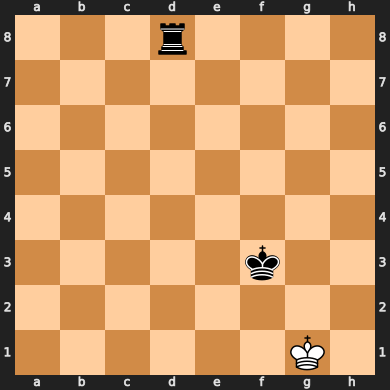

In [ ]:
b = chess.Board('3r4/8/8/8/8/5k2/8/6K1 w - -')
print(list(b.legal_moves))
b

In [ ]:
def test():
    s = set()
    for i in range(400000*64*10):
        s.add(f'3r4/8/8/8/8/5k2/8/6K1 w - {i}')

In [ ]:
import sys

In [ ]:
x = 0b1111111111111111111111111
x = int(x)
print(x)
sys.getsizeof(x)

33554431


28

In [ ]:
chess.Board().epd()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'

In [ ]:
%%time
s = {x for x in range(25000000)}
if s & {19000000}: print("Found")
del s

Found
CPU times: user 2.25 s, sys: 1.46 s, total: 3.71 s
Wall time: 5.55 s


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>